In [1]:
import pandas as pd
import os
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from PIL import Image
from torch import nn
from tqdm import tqdm
from torcheval.metrics import Mean
import matplotlib.pyplot as plt
from torch.nn.utils.clip_grad import clip_grad_norm_
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

In [2]:
train_df = pd.read_csv('train/metadata.csv')
test_df = pd.read_csv('test/metadata.csv')

In [17]:
colors = {
    'blue': 0,
    'brown':1,
    'red': 2,
    'yellow': 3,
    'green': 4
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
bs = 2
lamb = 100

In [4]:
class AshrafiSet(Dataset):

    def __init__(self, data, phase):
        self.X = list()
        self.gt = list()
        self.con = list()
        to_tensor = v2.Compose([v2.Resize((256, 256)), v2.ToTensor()])
        for i, row in data.iterrows():
            if i % 25 == 0:
               X = Image.open(f'{phase}/inputs/{row["input"]}')
            y_image = Image.open(f'{phase}/targets/{row["target"]}')
            hair, shirt = colors[row['hair']], colors[row['shirt']]

            self.con.append(torch.LongTensor([hair, shirt]))
            self.X.append(to_tensor(X))
            self.gt.append(to_tensor(y_image))

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, ind):
        return self.X[ind], self.gt[ind], self.con[ind]

In [5]:
train_set = AshrafiSet(train_df, 'train')
test_set = AshrafiSet(test_df, 'test')

/home/vahid/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [18]:
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_set, batch_size=5)

# NeuralNetwork


In [9]:
class Block(nn.Module):

    def __init__(self, in_f, out_f, dropout=0.5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_f, out_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(dropout),
            nn.Conv2d(out_f, out_f, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_f),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.layers(x)


    
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(colors), 256)
        self.unet = smp.UnetPlusPlus(in_channels=4, classes=3)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, conditions=None):

        conditions = self.dropout(self.embedding(conditions))
        labels = conditions.unsqueeze(1).repeat(1, 1, 128, 1)
        x = torch.cat([x, labels], dim=1)
        output = self.dropout(self.unet(x))
        output = self.tanh(output)
        return output

    
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(colors), embedding_dim=256)
        block1 = Block(7, 64)
        block2 = Block(64, 128)
        self.mp = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        block3 = Block(128, 256)
        block4 = Block(256, 512)
        block5 = Block(512, 256)
        block6 = Block(256, 64)
        self.blocks = nn.ModuleList([block1, block2, block3, block4, block5, block6])
        self.head = nn.Linear(1024, 1)

        
    def forward(self, x, y, conditions):
        x = torch.cat([x, y], dim=1)
        conditions = self.embedding(conditions)
        conditions = conditions.unsqueeze(1).repeat(1, 1, 128, 1)
        x = torch.cat([conditions, x], dim=1)
        for module in self.blocks:
            x = module(x)
            x = self.mp(x)
            
        x = x.flatten(1)
        y = self.head(x)
        return y

In [25]:
# gen = Generator().to(device)
# disc = Discriminator().to(device)
gen = torch.load('gen.pt')
disc = torch.load('disc.pt')
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(disc.parameters())
l1_loss = nn.L1Loss()
disc_loss = nn.BCEWithLogitsLoss()

# Training

In [26]:
def train_one_epoch(disc, gen, loader, d_loss, l1_fn, lamb, g_optimizer, d_optimizer):
    gen.train()
    disc.train()
    mean_d = Mean().to(device)
    mean_g = Mean().to(device)
    with tqdm(loader, unit='batch') as tep:
        for x, y, cond in tep:
            x, y, cond = x.to(device), y.to(device), cond.to(device)
            valid = torch.ones([bs, 1]).to(device)
            fake = torch.zeros([bs, 1]).to(device)
            for i in range(5):
                loss_disc_real = d_loss(disc(x, y, cond), valid)
                gen_outputs = gen(x, cond)

                loss_disc_fake = d_loss(disc(x, gen_outputs, cond), fake)

                disc_loss = loss_disc_fake + loss_disc_real
                disc_loss.backward()
                d_optimizer.step()
                d_optimizer.zero_grad()

            g_optimizer.zero_grad()

            gen_outputs = gen(x, cond)

            gen_loss = d_loss(disc(gen_outputs, y, cond), valid)
            l1_loss = l1_fn(gen_outputs, y)

            total_gen_loss = gen_loss + (lamb * l1_loss)

            total_gen_loss.backward()
            clip_grad_norm_(gen.parameters(), 0.5)
            g_optimizer.step()
            mean_d.update(disc_loss)
            mean_g.update(total_gen_loss)
            
            tep.set_postfix(loss_gan=mean_g.compute().item(), loss_disc=mean_d.compute().item())
        return disc, gen, mean_g.compute().item(), mean_d.compute().item()


def evaluate(disc, gen, loader, d_loss, l1_fn, lamb):
    gen.eval()
    disc.eval()
    mean_d = Mean().to(device)
    mean_g = Mean().to(device)
    for x, y, cond in loader:
        x, y, cond = x.to(device), y.to(device), cond.to(device)
        valid = torch.ones([5, 1]).to(device)
        fake = torch.zeros([5, 1]).to(device)

        gen_outputs = gen(x, cond)

        gen_loss = d_loss(disc(gen_outputs, y, cond), valid)
        l1_loss = l1_fn(gen_outputs, y)

        total_gen_loss = gen_loss + (lamb * l1_loss)
        mean_g.update(total_gen_loss)
    loss = mean_g.compute().item()
    print('g loss : ', loss)
    return loss

In [27]:
best_loss_valid = 1e+4
loss_g_train_hist = list()
loss_d_train_hist = list()
loss_valid_hist = list()
epoch_counter = 0

In [28]:
for i in range(1000):
        disc, gen, loss_g, loss_d = train_one_epoch(disc, 
                                                    gen, 
                                                    train_loader, 
                                                    disc_loss,
                                                    l1_loss, 
                                                    lamb, 
                                                    gen_optimizer, 
                                                    disc_optimizer)
        loss_valid = evaluate(disc, gen, test_loader, disc_loss, l1_loss, lamb)
        
        epoch_counter += 1
        loss_valid_hist.append(loss_valid)
        loss_d_train_hist.append(loss_d)
        loss_g_train_hist.append(loss_g)
        if loss_valid < best_loss_valid:
            best_loss_valid = loss_valid
            torch.save(gen , 'gen.pt')
            print('generator saved')

100%|████████| 50/50 [00:16<00:00,  2.97batch/s, loss_disc=0.805, loss_gan=11.2]


g loss :  5.035934829711914
generator saved


100%|███████| 50/50 [00:17<00:00,  2.94batch/s, loss_disc=0.0301, loss_gan=10.6]


g loss :  5.122911643981934


100%|██████| 50/50 [00:16<00:00,  2.98batch/s, loss_disc=0.00277, loss_gan=10.4]


g loss :  5.246810102462769


100%|█████| 50/50 [00:17<00:00,  2.92batch/s, loss_disc=0.000925, loss_gan=10.3]


g loss :  5.07808198928833


100%|█████████| 50/50 [00:16<00:00,  3.02batch/s, loss_disc=0.02, loss_gan=10.4]


g loss :  5.069959926605224


100%|███████| 50/50 [00:16<00:00,  3.02batch/s, loss_disc=0.000749, loss_gan=10]


g loss :  4.735760354995728
generator saved


100%|█████| 50/50 [00:16<00:00,  3.06batch/s, loss_disc=0.000243, loss_gan=9.99]


g loss :  5.030863285064697


100%|██████| 50/50 [00:16<00:00,  3.05batch/s, loss_disc=0.000166, loss_gan=9.9]


g loss :  5.4935344696044925


100%|██████| 50/50 [00:16<00:00,  2.97batch/s, loss_disc=0.00012, loss_gan=9.82]


g loss :  5.1584625244140625


100%|██████| 50/50 [00:16<00:00,  3.07batch/s, loss_disc=8.88e-5, loss_gan=9.87]


g loss :  4.875340318679809


100%|██████| 50/50 [00:15<00:00,  3.13batch/s, loss_disc=8.96e-5, loss_gan=9.81]


g loss :  4.8537147521972654


100%|██████| 50/50 [00:16<00:00,  3.09batch/s, loss_disc=5.98e-5, loss_gan=9.69]


g loss :  5.0526707649230955


100%|██████| 50/50 [00:15<00:00,  3.13batch/s, loss_disc=3.22e-5, loss_gan=9.85]


g loss :  5.139416694641113


100%|██████| 50/50 [00:16<00:00,  3.02batch/s, loss_disc=5.91e-5, loss_gan=9.62]


g loss :  5.083332824707031


100%|██████| 50/50 [00:16<00:00,  3.04batch/s, loss_disc=1.95e-5, loss_gan=9.46]


g loss :  4.833030700683594


100%|██████| 50/50 [00:16<00:00,  3.08batch/s, loss_disc=2.05e-5, loss_gan=9.36]


g loss :  4.587999439239502
generator saved


 12%|▊      | 6/50 [00:02<00:15,  2.81batch/s, loss_disc=4.08e-5, loss_gan=9.27]


KeyboardInterrupt: 

In [ ]:
disc = torch.load('disc.pt')

In [29]:
gen = torch.load('gen.pt')

In [30]:
torch.cuda.empty_cache()

In [31]:
def visualize(x, y):
    fig = plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.title('generated Image')
    plt.imshow(x.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title('real Image')

    plt.imshow(y.permute(1, 2, 0))
    plt.axis("off")


In [87]:
x, y, cond = next(iter(test_loader))

In [88]:
x.shape

torch.Size([5, 3, 256, 256])

In [89]:
with torch.no_grad():
    gen.eval()
    out = gen(x.to(device), cond.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


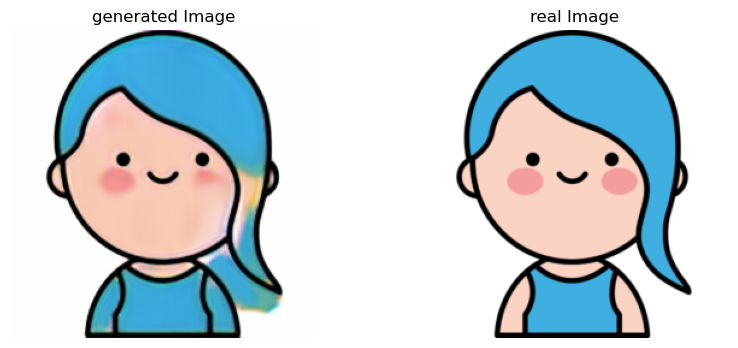

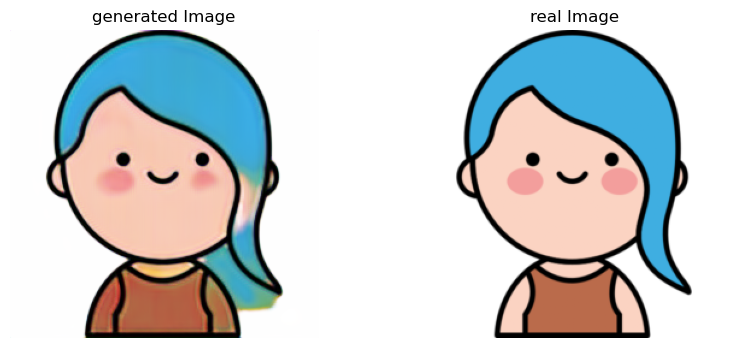

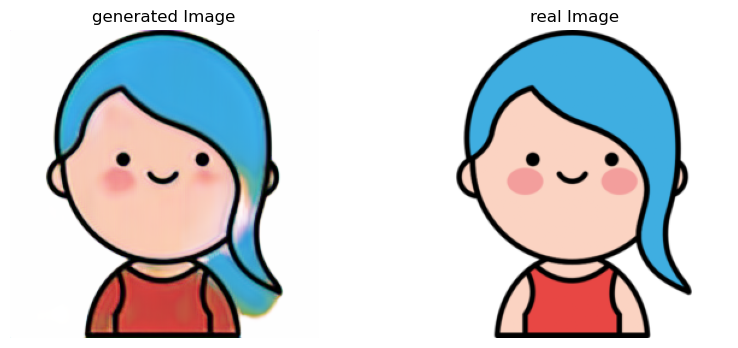

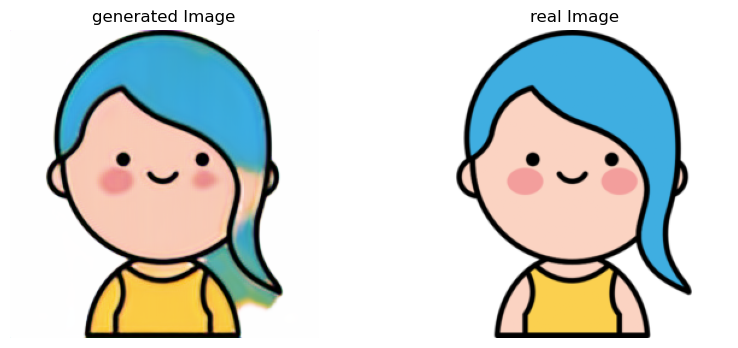

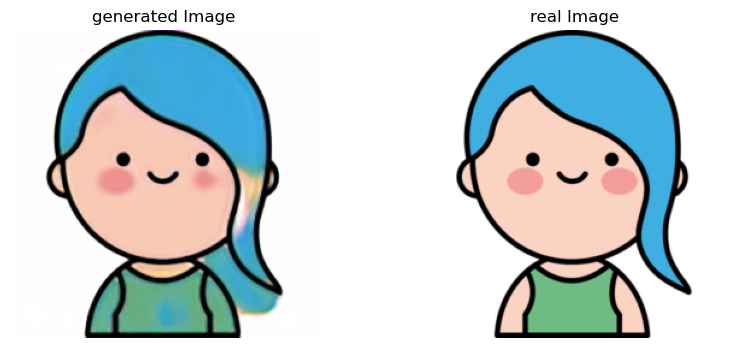

In [90]:
for i in range(len(x)):
    
    visualize(out[i].cpu(), y.cpu()[i])